<div>
<h1>Autocorrelation Phase Matrix Homework</h1> 
</div>

Follow the instructions in the document. 

Print, plot and play (when possible) all the intermediate results that you obtain in a readable format.

Please, use the proposed variables names for the output of each section.

### Import your libraries here

In [1]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy as sp

### Define utilities functions

In [2]:
def warp(x, low, interval):
    return np.remainder(x - low, interval) + low


def princarg(x):
    return warp(x, -np.pi, 2*np.pi)


def compute_novelty(x, Fs=1, N=512, H=256):
    """Compute complex-domain novelty function
    """     
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs/H
    mag = np.abs(X)
    
    phase = np.angle(X)/(2*np.pi)
    
    unwr_phase = np.zeros_like(X, dtype=float);
    for i in np.arange(X.shape[1]):
        unwr_phase[:,i] = np.unwrap( np.angle(X[:,i]) )
    
    phase_shift = unwr_phase[:,2:] - 2*unwr_phase[:,1:-1] + unwr_phase[:,0:-2]
    phase_shift = princarg(phase_shift)    
    
    
    amp_pred = mag[:,1:-1]
    amp_true = mag[:,2:]
    
    novelty_complex = (amp_pred**2 + amp_true**2 - 2 * amp_pred * amp_true * np.cos(phase_shift))
    
    # Half wave rectification
    novelty_complex[novelty_complex<0]=0
    
    novelty_complex = np.sqrt(novelty_complex)
    
    novelty_complex = np.sum(novelty_complex, axis=0)
    novelty_complex = np.concatenate((novelty_complex, np.array([0, 0])))
    
    return novelty_complex, Fs_feature

In [30]:
def compute_APM(x, lags):
    N = len(x)
    n_lags = len(lags)
    max_lag = lags[-1]                   
    P = np.zeros((n_lags, max_lag))
    C = np.zeros((n_lags, max_lag))
    # for all the lags k
    for lag_index in np.arange(n_lags):
        k = lags[lag_index]                   
        for phi in np.arange(k):
            n = np.ceil((N-phi)/k)
            i = np.array(phi + k*np.arange(n), dtype=int) 
            P[lag_index,phi] = np.sum(x[i[0:-1]] * x[i[1:]])    
            C[lag_index,phi] = n-1                               
    C[C==0]=1 

    return P

In [4]:
def smooth(x, win_length=3, win_type='boxcar'):
    ### your code here ###
    return 

In [5]:
def smooth(x, win_length=11, win_type='boxcar'):
    if x.ndim != 1:
        raise ValueError('smooth only accepts 1 dimension arrays.')

    if x.size < win_length:
        raise ValueError('Input vector needs to be bigger than window size.')

    if win_length<3:
        return x
    # mirror pad
    s = np.pad(x, int(win_length/2), mode='reflect')    
    # create window
    w = sp.signal.windows.get_window(win_type, win_length)
    # convolve with normalized window
    y=np.convolve(w/w.sum(), s, mode='valid')
    
    #normalize
    y=y/(np.max(y))
    
    #padding for garantee the same len of x and y
    pad_width = len(y) - len(x)
    y = np.pad(y, pad_width)
    
    # return the useful part of y
    return y

## Input preparation

### Define audio signals

In [6]:
x_times = np.asarray([0, 0.5, 0.5*2, 0.5*3])
y_times = np.asarray([0 , 2/3, 2/3*2])
Fs=22050

In [7]:
x = librosa.clicks(sr=Fs, click_duration=0.5, times=x_times)
y = librosa.clicks(sr=Fs, click_duration=2/3, times=y_times)
z = np.sum((x,y), axis=0)

In [50]:
ipd.display(ipd.Audio(x, rate=Fs))
ipd.display(ipd.Audio(y, rate=Fs))
ipd.display(ipd.Audio(z, rate=Fs))

### Compute novelty curves

In [9]:
nov_x, Fs_nov = compute_novelty(x,Fs=Fs)
nov_y, Fs_nov = compute_novelty(y,Fs=Fs)
nov_z, Fs_nov = compute_novelty(z,Fs=Fs)

#Nomalization
nov_x = nov_x/(np.max(nov_x))
nov_y = nov_y/(np.max(nov_y))
nov_z = nov_z/(np.max(nov_z))

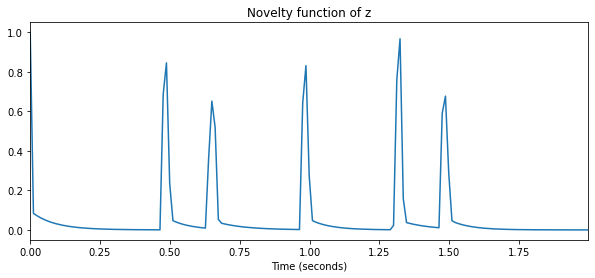

In [58]:
#Novelty function plot
feature_time_axis = np.arange(nov_z.shape[0]) / Fs_nov

plt.figure(figsize=(10, 4))
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Novelty function of z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, nov_z)
plt.show()

## Autocorrelation Phase Matrix Parameters

In [59]:
#K lags found
kmin = 20
kmax = 129
lags = np.arange(kmin,kmax)

## Autocorrelation Phase Matrix Computation

### Apply smoothing

In [60]:
#Apply the modified smooth function
smooth_nov_x = smooth(nov_x,win_length=4)
smooth_nov_y = smooth(nov_y,win_length=4)
smooth_nov_z = smooth(nov_z,win_length=4)

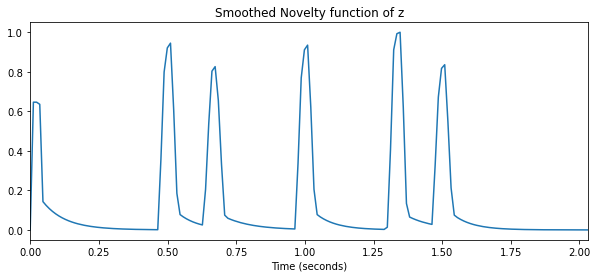

In [66]:
#Plot the smoothed novelty function
feature_time_axis = np.arange(smooth_nov_z.shape[0]) / Fs_nov

plt.figure(figsize=(10, 4))
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Smoothed Novelty function of z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, smooth_nov_z)
plt.show()

### Add constant noise

In [72]:
#Generate constant noise
noise_x = 0.02+ 0*np.random.randn(len(smooth_nov_x))
noise_y = 0.02+ 0*np.random.randn(len(smooth_nov_y))
noise_z = 0.02+ 0*np.random.randn(len(smooth_nov_z))

In [73]:
#Add noise to the smoothed novelty function
noisy_smooth_nov_x = smooth_nov_x + noise_x
noisy_smooth_nov_y = smooth_nov_y + noise_y
noisy_smooth_nov_z = smooth_nov_z + noise_z

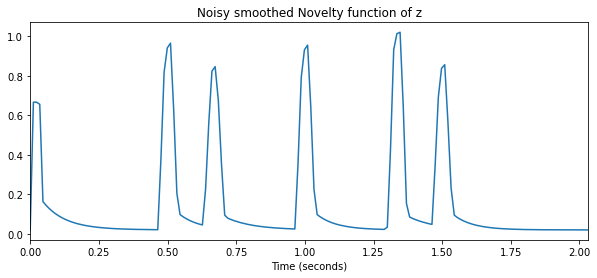

In [74]:
#Plot the smoothed novelty function
feature_time_axis = np.arange(noisy_smooth_nov_z.shape[0]) / Fs_nov

plt.figure(figsize=(10, 4))
plt.xlim([feature_time_axis[0], feature_time_axis[-1]])
plt.title('Noisy smoothed Novelty function of z')
plt.xlabel('Time (seconds)')
plt.plot(feature_time_axis, noisy_smooth_nov_z)
plt.show()

### Compute APM

In [77]:
P_x = compute_APM(noisy_smooth_nov_x, lags)
P_y = compute_APM(noisy_smooth_nov_y, lags)
P_z = compute_APM(noisy_smooth_nov_z, lags)

print("Shape of x:",P_x.shape)
print("Shape of y:",P_y.shape)
print("Shape of z:",P_z.shape)

Shape of x: (109, 128)
Shape of y: (109, 128)
Shape of z: (109, 128)


## Autocorrelation Phase Matrix Tempo Analysis

In [19]:
BPM_x =
BPM_y =

SyntaxError: invalid syntax (<ipython-input-19-c90e90392d1c>, line 1)

## Autocorrelation Phase Matrix Rhythmic Analysis

In [ ]:
import numpy as np
apm_dict = np.load('apm_dict.npy', allow_pickle=True).item()

In [ ]:
pulses = 

In [ ]:
click_track = 